In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/trial0.csv', index_col='time')

# omit first 100 due to errors in setting up apparatus in beginning
df = df.iloc[100:]

SR = 25

Text(0.5, 0, 'time (s)')

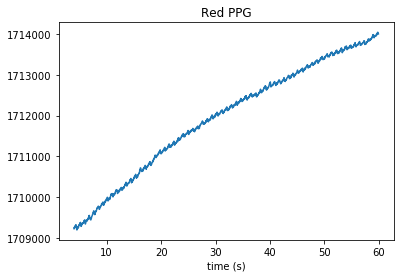

In [2]:
plt.plot(df['Reflect: Red']);
plt.title('Red PPG')
plt.xlabel('time (s)')

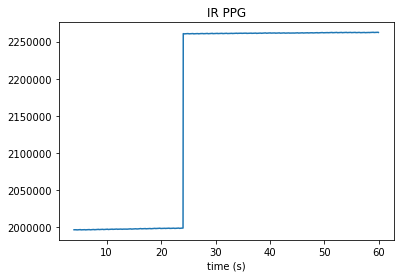

In [3]:
plt.plot(df['Reflect: IR']);
plt.title('IR PPG')
plt.xlabel('time (s)');

In [4]:
from pyts import decomposition
import heartpy as hp
from scipy import signal

def extract_acdc(F, L, SR):
    """
    F: time series numpy array of PPG signal
    
    Returns: 
    ac_signal
    dc_signal
    """
    ssa = decomposition.SingularSpectrumAnalysis(window_size = L)
    F_ssa = ssa.fit_transform(F.reshape(1, -1))
    dc = F_ssa[0]
    ac = np.sum(F_ssa[1:], axis=0)
    filtered_ac = hp.filter_signal(ac, 
                                  cutoff = [.7, 3.5], 
                                  filtertype = 'bandpass',
                                  sample_rate = SR, 
                                  order = 4,
                                  return_top = False)
    return dc, filtered_ac

def peak_detect_acdc(ac, dc, bpm, x_label):
    
    time = x_label[-1] - x_label[0]
    samples = len(x_label)
    
    # doesn't give result I want when putting asa param for find_peaks -- not really sure why
    # bpm here is taken directly from transmission pulseox, in practice we would use estimate from heartpy process? doesn't seem great for error
    width = 60 / bpm
    # so dist is used instead
    dt = time / samples
    dist = width / dt
    # give room for error
    dist -= .2 * dist

    # find peaks and troughs
    inv_ac = -ac
    # find peaks without dc comp to make peak detection easier
    trough_idx, _ = signal.find_peaks(inv_ac, distance=dist)
    peak_idx, _ = signal.find_peaks(ac, distance=dist)

    clean_signal = ac + dc

#     plt.plot(x_label, clean_signal);
#     plt.plot(x_label[trough_idx], clean_signal[trough_idx], 'rx');
#     plt.plot(x_label[peak_idx], clean_signal[peak_idx], 'bo')

    peakDc = []
    peakAc = []

    # go through for every peak-trough-peak group in our sequence
    for i in range(len(trough_idx) - 1):
        # pick two arbitrary troughs and the peak in between
        tidx0 = trough_idx[i]
        tidx1 = trough_idx[i + 1]
        pidx = peak_idx[i]
        j = i
        while pidx < tidx0:
            j += 1
            pidx = peak_idx[j]

        # find parameters for best fit line between two trough
        m = (clean_signal[tidx1] - clean_signal[tidx0]) / (x_label[tidx1] - x_label[tidx0])
        b = clean_signal[tidx0] - m * x_label[tidx0]

#         # test line
#         testx = np.linspace(x_label[tidx0], x_label[tidx1], 10)
#         testy = testx * m + b
#         plt.plot(testx, testy)

        # find AC and DC components using the best fit line
        peakVal = clean_signal[pidx]
        peakDcTemp = m * x_label[pidx] + b
        peakAcTemp = peakVal - peakDcTemp

        peakDc.append(peakDcTemp)
        peakAc.append(peakAcTemp)

#     irDcVar = np.var(irDc)
#     irAcVar = np.var(irAc)
#     print(irDcVar, irAcVar)

#     plt.xlabel('time (s)')
#     plt.title('IR Channel Peak/Trough Detection')

    peakDc = sum(peakDc) / len(peakDc)
    peakAc = sum(peakAc) / len(peakAc)

    return peakDc, peakAc


def linear_spo2(red_ac, red_dc, ir_ac, ir_dc):    
    # calculate R
    redRatio = red_ac / red_dc
    irRatio = ir_ac / ir_dc
    R = redRatio / irRatio

    # linear fit
    lin_spo2 = 104 - 17 * R
    return lin_spo2

def quadratic_spo2(red_ac, red_dc, ir_ac, ir_dc):
    # calculate R
    redRatio = red_ac / red_dc
    irRatio = ir_ac / ir_dc
    R = redRatio / irRatio

    # using quadratic fit
    a = 1.5958422
    b = -34.6596622
    c = 112.6898759
    quad_spo2 = a * (R**2) + b * R + c
    return quad_spo2

In [5]:
real_spo2 = []
lin_spo2 = []
quad_spo2 = []

for i in range(df.shape[0] // 100):
    # pull out 100 samples as a single trial
    df_trial = df.iloc[i * 100 : (i + 1) * 100]
    real_spo2.append(df_trial['spo2'].mean())
    bpm = df_trial['bpm'].mean()
    L = 50
    
    # red analysis
    red_F = df_trial['Reflect: Red'].to_numpy()
    red_dc, red_ac = extract_acdc(red_F, L, SR)
    red_peak_dc, red_peak_ac = peak_detect_acdc(red_ac, red_dc, bpm, df_trial.index)
    
    # ir analysis
    ir_F = df_trial['Reflect: IR'].to_numpy()
    ir_dc, ir_ac = extract_acdc(ir_F, L, SR)
    ir_peak_dc, ir_peak_ac = peak_detect_acdc(ir_ac, ir_dc, bpm, df_trial.index)

    lin_spo2.append(linear_spo2(red_peak_ac, red_peak_dc, ir_peak_ac, ir_peak_dc))
    quad_spo2.append(quadratic_spo2(red_peak_ac, red_peak_dc, ir_peak_ac, ir_peak_dc))

Text(0.5, 1.0, 'SpO2')

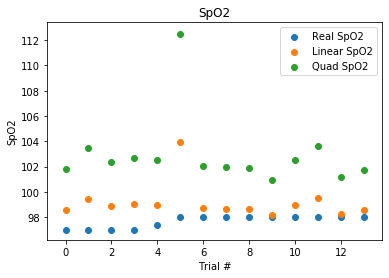

In [6]:
columns = {'real_spo2' : real_spo2, 'lin_spo2' : lin_spo2, 'quad_spo2' : quad_spo2}
results = pd.DataFrame(columns)
results.rename_axis(index='trials')

results1 = results.drop(6, axis=0)

plt.scatter(results.index, results['real_spo2'])
plt.scatter(results.index, results['lin_spo2'])
plt.scatter(results.index, results['quad_spo2'])
plt.legend(['Real SpO2', 'Linear SpO2', 'Quad SpO2'])
plt.xlabel('Trial #')
plt.ylabel('SpO2')
plt.title('SpO2')

In [7]:
# looking at error
results['lin_error'] = abs((results.lin_spo2 - results.real_spo2) / results.real_spo2)
results['quad_error'] = abs((results.quad_spo2 - results.real_spo2) / results.real_spo2)
results1 = results.drop(6, axis=0)


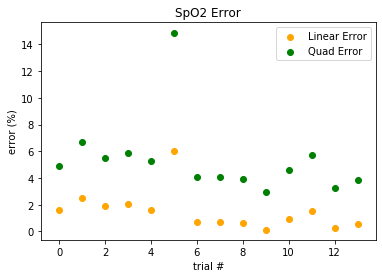

In [8]:
plt.scatter(results.index, results.lin_error * 100, color='orange')
plt.scatter(results.index, results.quad_error * 100, color='green')
plt.title('SpO2 Error')
plt.xlabel('trial #')
plt.ylabel('error (%)')
plt.legend(['Linear Error', 'Quad Error'])